<a href="https://colab.research.google.com/github/aldegundescastro/Bootcamp-Machine-Learning-Training/blob/main/desafio_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Transfer Learning em Python

### Buscando desenvolver familiaridade com as estruturas e documentação do TensorFlow e Keras, foi realizado transfer-learning em uma rede MobileNetV2, congelando a base convolucional e treinando o modelo apenas nas camadas finais para classificação do dataset cats_vs_dogs.


# Transfer-Learning 1
### Adaptado de TensorFlow Core Tutoriais (Transferência de aprendizado e ajuste fino) + GPT.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers



Total de imagens de treino: 20936
Total de imagens de validação: 1163
Total de imagens de teste: 1163


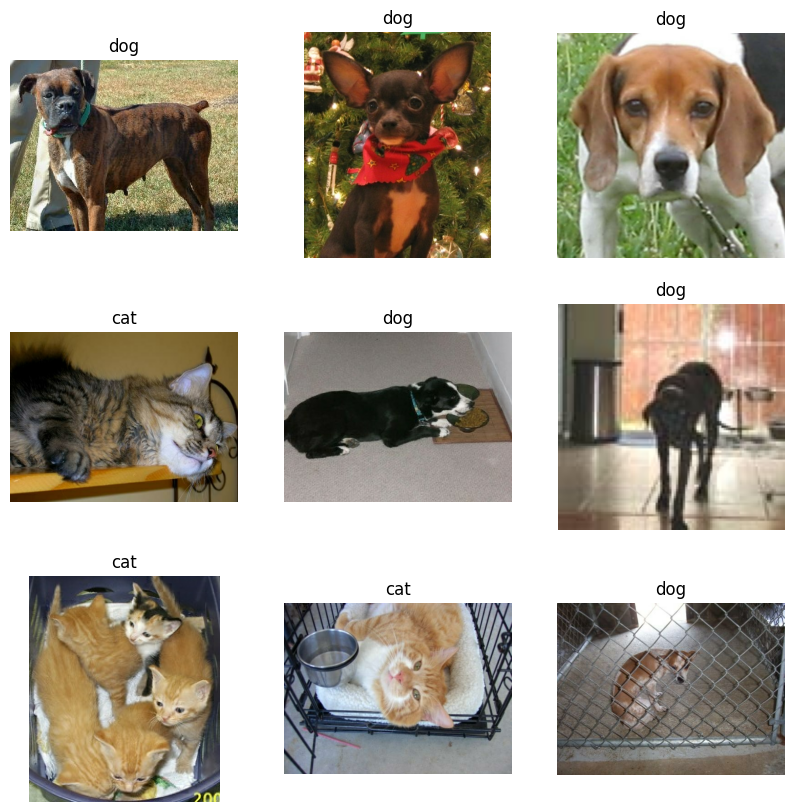

In [3]:
# 1. Carregando e Preparando o Dataset 'cats_vs_dogs'

# Carrega o dataset 'cats_vs_dogs' do TensorFlow Datasets
# Divide o dataset em treino, validação e teste
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:90%]', 'train[90%:95%]', 'train[95%:]'],
    with_info=True,
    as_supervised=True,
)

print(f"Total de imagens de treino: {len(raw_train)}")
print(f"Total de imagens de validação: {len(raw_validation)}")
print(f"Total de imagens de teste: {len(raw_test)}")

get_label_name = metadata.features['label'].int2str

# Exibe algumas imagens do dataset de treino
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(raw_train.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(get_label_name(label))
  plt.axis("off")
plt.show()

In [4]:
## 2. Pré-processamento e Augmentation dos Dados
IMG_SIZE = 160 # Tamanho da imagem para o modelo MobileNetV2
BATCH_SIZE = 12

def format_example(image, label):
  """
  Redimensiona e normaliza as imagens para o formato esperado pelo modelo.
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

# Aplica a função de formatação aos datasets
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# Embaralha e cria batches dos datasets
train_batches = train.shuffle(len(raw_train)).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

"""
# Configurar o conjunto de dados para desempenho usando pré-busca em buffer
AUTOTUNE = tf.data.AUTOTUNE
train_batches = train_batches.prefetch(buffer_size=AUTOTUNE)
validation_batches = validation_batches.prefetch(buffer_size=AUTOTUNE)
test_batches = test_batches.prefetch(buffer_size=AUTOTUNE)


# Data Augmentation (Aumento de Dados)
data_augmentation = tf.keras.Sequential([layers.RandomFlip('horizontal'),
                                         layers.RandomRotation(0.2),])

# Exibe Aumento de Dados
for image, _ in train_batches.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
"""


"\n# Configurar o conjunto de dados para desempenho usando pré-busca em buffer\nAUTOTUNE = tf.data.AUTOTUNE\ntrain_batches = train_batches.prefetch(buffer_size=AUTOTUNE)\nvalidation_batches = validation_batches.prefetch(buffer_size=AUTOTUNE)\ntest_batches = test_batches.prefetch(buffer_size=AUTOTUNE)\n\n\n# Data Augmentation (Aumento de Dados)\ndata_augmentation = tf.keras.Sequential([layers.RandomFlip('horizontal'),\n                                         layers.RandomRotation(0.2),])\n\n# Exibe Aumento de Dados\nfor image, _ in train_batches.take(1):\n  plt.figure(figsize=(10, 10))\n  first_image = image[0]\n  for i in range(9):\n    ax = plt.subplot(3, 3, i + 1)\n    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))\n    plt.imshow(augmented_image[0] / 255)\n    plt.axis('off')\n"

In [5]:
## 3. Construindo o Modelo de Transfer Learning

# Carrega o modelo MobileNetV2 pré-treinado no ImageNet, sem a camada de classificação (include_top=False)
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
#base_model =      tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

# Congela os pesos do modelo base para não serem treinados
base_model.trainable = False

# Adiciona um cabeçalho de classificação personalizado
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1) # Saída única para classificação binária (gato ou cachorro)

# Constrói o modelo final
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [6]:
## 4. Compilando e Treinando o Modelo

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

# Treina o modelo
initial_epochs = 2
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/2
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 66s 16ms/step - accuracy: 0.8690 - loss: 0.2616 - val_accuracy: 0.9733 - val_loss: 0.0786
Epoch 2/2
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 75s 12ms/step - accuracy: 0.9752 - loss: 0.0679 - val_accuracy: 0.9785 - val_loss: 0.0592


In [7]:
## 5. Avaliando o Modelo

loss, accuracy = model.evaluate(test_batches)
print(f"Acurácia no conjunto de teste: {accuracy}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9857 - loss: 0.0431
Acurácia no conjunto de teste: 0.985382616519928


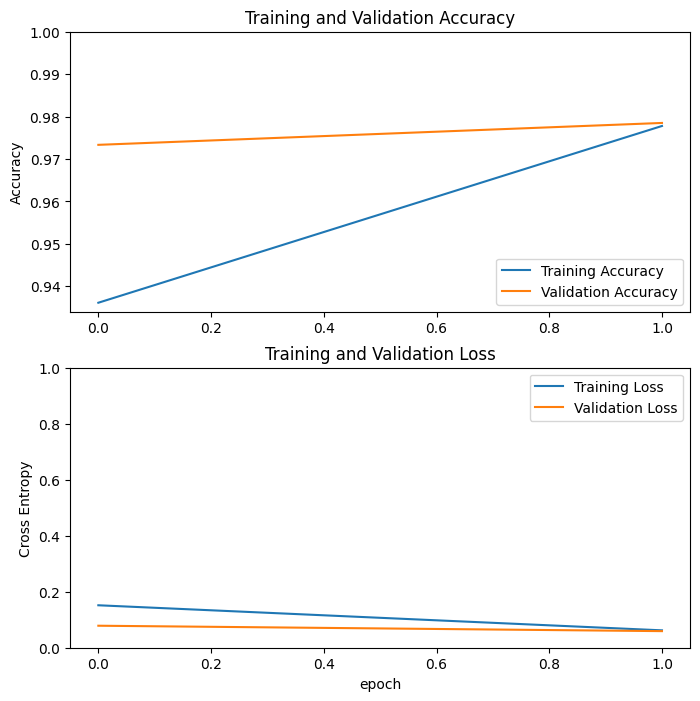

In [9]:
## 5.1. Plotando os Gráficos de Treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
## 6. Fine-tuning (Ajuste Fino)

# Descongela as camadas superiores do modelo base para ajuste fino
base_model.trainable = True

# Descongela a partir da camada 100
fine_tune_at = 100

# Congela todas as camadas antes da 'fine_tune_at'
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Compila o modelo para o fine-tuning com uma taxa de aprendizado menor
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

# Continua o treinamento (fine-tuning)
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

# Avalia o modelo após o fine-tuning
loss, accuracy = model.evaluate(test_batches)
print(f'Acurácia no conjunto de teste após fine-tuning: {accuracy}')

In [ ]:
## 7. Plotando os Gráficos de Treinamento

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acurácia de Treino')
plt.plot(val_acc, label='Acurácia de Validação')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Início do Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda de Treino')
plt.plot(val_loss, label='Perda de Validação')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Início do Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.xlabel('época')
plt.show()


# Transfer-Learning 2
### Adaptado de TensorFlow Core Tutoriais: Transferência de aprendizado e ajuste fino  (https://www.tensorflow.org/tutorials/images/transfer_learning?hl=pt-br)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [18]:
# 1. Carregando e Preparando o Dataset 'cats_and_dogs'
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.join(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


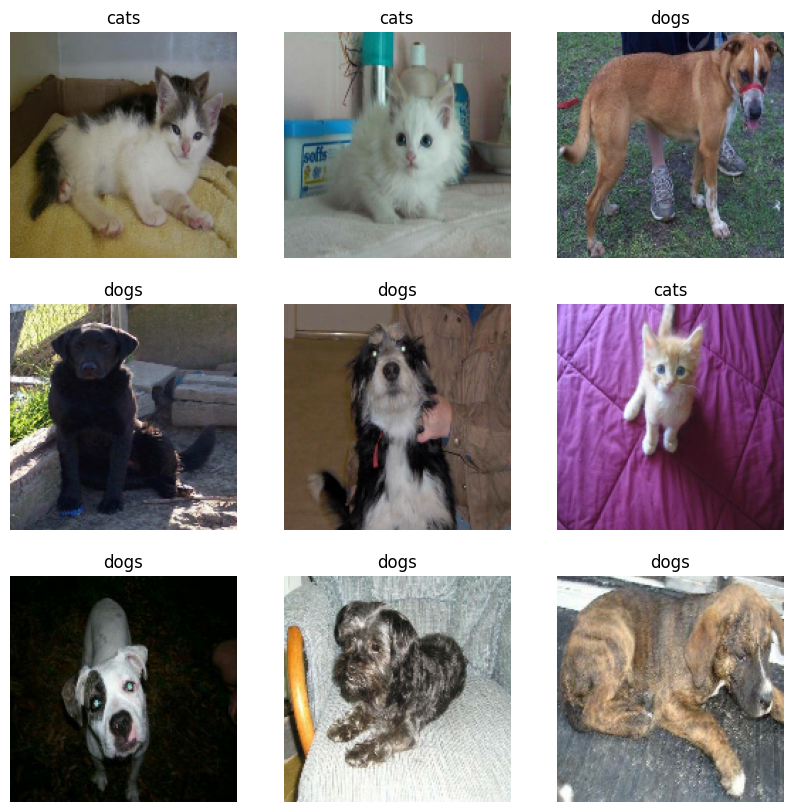

In [19]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
# Cria um conjunto de teste
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [21]:
# Configurar o conjunto de dados para desempenho usando pré-busca em buffer
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

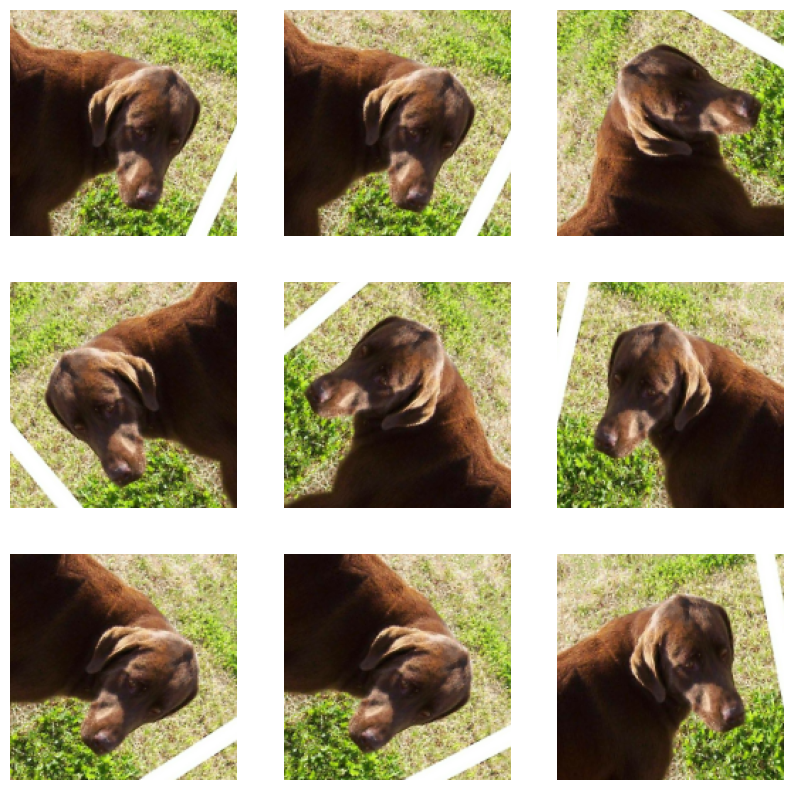

In [22]:
# Aumento de dados
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [23]:
# Redimensionar valores de pixel
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [26]:
# Crie o modelo base a partir do modelo pré-treinado MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
# base_model =      tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [28]:
# O congelamento (definindo layer.trainable = False) evita que os pesos em uma determinada camada sejam atualizados durante o treinamento
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [30]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [31]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [32]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5755 - loss: 0.6777
initial loss: 0.67
initial accuracy: 0.56


In [34]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5342 - loss: 0.7190 - val_accuracy: 0.6856 - val_loss: 0.4721
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7058 - loss: 0.5241 - val_accuracy: 0.8082 - val_loss: 0.3457
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7773 - loss: 0.4133 - val_accuracy: 0.8676 - val_loss: 0.2748
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8333 - loss: 0.3405 - val_accuracy: 0.9109 - val_loss: 0.2182
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8640 - loss: 0.3164 - val_accuracy: 0.9196 - val_loss: 0.1987
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8690 - loss: 0.2888 - val_accuracy: 0.9332 - val_loss: 0.1705
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8859 - loss: 0.2534 - val_accuracy: 0.9369 - val_loss: 0.1568
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9004 - loss: 0.2342 - val_accuracy: 0.9505 - v

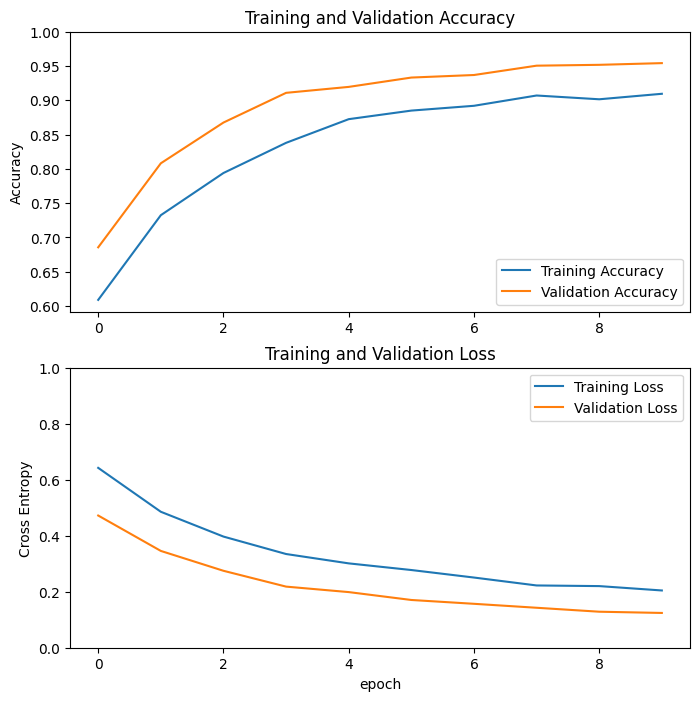

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()